# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Classifying Chest X-rays by Disease with Neural Networks
## CS109b: Advanced Topics in Data Science



**Harvard University**<br/>
**Spring 2022**<br/>
**Team members**: Alex Lim, Jinjie Liu, Steven Worthington


<hr style="height:2pt">

# Introduction

## i. About This Notebook

This notebook represents a summary of a series of exploratory analysis, wherein we attempt various approaches to classify X-ray images into 14 disease classes and a 'no finding' class.

## ii. Research Questions

After initial exploration and cleaning of the data, we have focused our efforts on the following research questions:

1. Which model architecture performs best for out-of-sample classification of the X-ray images into the 14 disease classes and 'no finding' class?

2. What features in the images and which layers in the model are driving the output classification?

## iii. Summary of Findings

Summarize here.


<a name="Notebook-Contents"></a>
# Notebook Contents

[Introduction](#Introduction)

[Setup](#Setup)

**[1. The Data and EDA](#1.-The-Data-and-EDA)**

- [1.1. The Data](#1.1.-The-Data)

- [1.2. Exploratory Data Analysis](#1.2.-Exploratory-Data-Analysis)

- [1.3. Major Findings](#1.3.-Major-Findings)

**[2. Research Questions](#2.-Research-Questions)**

**[3. Data Preprocessing](#3.-Data-Preprocessing)**

- [3.1. Image Data](#3.1.-Image-Data)

- [3.2. Label Data](#3.2.-Label-Data)

- [3.3 Combined Data](#3.3-Combined-Data)

**[4. Model Training](#4.-Model-Training)**

- [4.1. Callbacks & Loss Functions](#4.1.-Callbacks-&-Loss-Functions)

- [4.2. Model Architecture](#4.2.-Model-Architecture)

- [4.3. Compile & Train](#4.3.-Compile-&-Train)

**[5. Model Evaluation](#5.-Model-Evaluation)**

- [5.1. Plot History](#5.1.-Plot-History)

- [5.2. Performance Metrics](#5.2.-Performance-Metrics)

**[6. Layer Visualizations](#6.-Layer-Visualizations)**

**[7. Conclusions](#7.-Conclusions)**

**[8. Future Work](#8.-Future-Work)**

**[9. References](#9.-References)**

# Setup

[Return to top](#Notebook-Contents)

The following sections include general setup code for:
1. Installing the necessary packages needed for data preparation, modeling, and visualization
2. Checking Colab GPU, CPU, and RAM allocations
3. Setting pseudo-random number seeds for reproducibility
4. Mounting Google Drive to Colab

### Install packages

In [ ]:
# Install additional packages

!pip install tf_keras_vis

     |████████████████████████████████| 53 kB 820 kB/s 


In [ ]:
import os
import pathlib
import re
from glob import glob
import random
import time
import zipfile
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import time
from itertools import islice, count
import warnings
warnings.simplefilter('ignore')
plt.style.use('seaborn-notebook')
sns.set_style('darkgrid')

from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.backend import clear_session
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Activation, Input 
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import BatchNormalization, GaussianNoise
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam, Adamax, Nadam, SGD, Adagrad, RMSprop
from tensorflow.keras.regularizers import l1_l2, l1, l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.initializers import he_normal, glorot_normal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K 
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Check GPU and CPU instances

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print(f"tensorflow version {tf.__version__}")
print(f"keras version {tf.keras.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.8.0
keras version 2.8.0
Eager Execution Enabled: True

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Check which GPU is assigned to the session
!nvidia-smi

Fri May  6 10:21:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    56W / 149W |    147MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Set seeds and mount Google Drive

In [ ]:
# Ensure replicable results
import os
import random as rn
SEED = 109
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
tf.random.set_seed(SEED)
np.random.seed(SEED)
rn.seed(SEED)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to Google Drive
base_path = 'drive/MyDrive/cs109b_final_project/'

Mounted at /content/drive


<a name="1.-The-Data-and-EDA"></a>
# 1. The Data and EDA

[Return to top](#Notebook-Contents)

<a name="1.1.-The-Data"></a>
## 1.1 The Data

The ChestXray8 dataset consists of 108,948 X-ray images from 32,717 patients. The X-rays have been classified into 8 disease categories (a total of \~24K images) and a 'no finding' category (a total of \~85K images) indicating the absence of evidence for disease. The disease categories are not mutually exclusive - that is, a single image can have multiple disease class labels. There is a large class imbalance, with some disease classes having \~1K images and others \~20K images. In addition, the non-disease class has many more images than all the disease classes combined. Some image labels appear to have been generated using natural language processing of radiological reports. For each X-ray, the image size is 1024 x 1024 pixels. Images have already been partitioned into training, evaluation, and testing sets, with meta-data files indicating which images belong to which set ("train_val_list.txt" and "test_list.txt"). Labels for training images are provided in a "Data_Entry_2017_v2020.csv" file and have been one-hot encoded in the "train_relabeled.csv" and “valid_relabeled.csv” files. In addition, there is a small subset (~1K) of relatively class-balanced images referenced in a "BBox_List_2017.csv" file.

<a name="1.2.-Exploratory-Data-Analysis"></a>
## 1.2 Exploratory Data Analysis

### Example X-ray images rescaled to 256x256 pixels

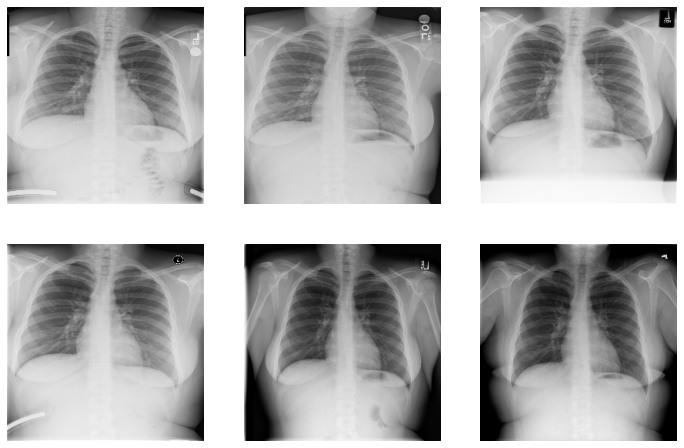

In [ ]:
# Plot small sample of X-ray images

num_imgs = 6
DIR = base_path + 'images_rescaled/images_001/'

combined_xray_images = np.array(
    [imageio.imread(os.path.join(DIR, f"00001335_00{i}.png")) for i in range(num_imgs)]
)

_, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes = axes.flatten()

for img, ax in zip(combined_xray_images, axes):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

### Data from "Data_Entry_2017_v2020.csv"

In [ ]:
# Load "Data_Entry_2017_v2020.csv"

labels_path = base_path + 'meta_data/Data_Entry_2017_v2020.csv'
data_entry_df = pd.read_csv(labels_path)

# Examine first 5 rows of dataframe
print(f'Shape of data_entry_df: {data_entry_df.shape}')
display(data_entry_df.head())

Shape of data_entry_df: (112120, 11)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


### Unique diseases

In [ ]:
# Determine the number of unique label combinations
disease_combinations = data_entry_df['Finding Labels'].unique()
print(f'Number of unique disease combinations: {len(disease_combinations)}\n')

# Split up disease_combinations into individual diseases - get number of unique labels
disease_combinations_split = [combination.split('|') for combination in disease_combinations]
diseases = list(set([disease for observation in disease_combinations_split for disease in observation]))

# Sanity check - how many unique diseases are present in the data
print(f'Number of unique diseases (including No Finding): {len(diseases)}\n')
print('Unique diseases (including No Finding): \n')
for disease in diseases:
  print(disease)

Number of unique disease combinations: 836

Number of unique diseases (including No Finding): 15

Unique diseases (including No Finding): 

No Finding
Effusion
Edema
Atelectasis
Pneumonia
Emphysema
Pneumothorax
Mass
Pleural_Thickening
Hernia
Cardiomegaly
Consolidation
Infiltration
Nodule
Fibrosis


### One-hot encode labels

In [ ]:
# One hot encode label data

# Rename image column
data_entry_df = data_entry_df.rename({'Image Index': 'image_filename'}, axis=1)

# Helper function to create one-hot encoded dataframe
@np.vectorize
def one_hot_disease(label, disease='No Finding'):
  if disease in label:
    return 1
  return 0

# Create one-hot encoded dataframe
one_hot_disease_df = data_entry_df[['image_filename']]
for disease in diseases:
  one_hot_disease_df[disease] = one_hot_disease(data_entry_df['Finding Labels'], disease=disease)

# Rename no finding column
#one_hot_disease_df = one_hot_disease_df.rename({'No Finding': 'No_Finding'}, axis=1)

# Examine first 5 rows of one_hot_disease_df dataframe
print(f'Shape of one_hot_disease_df: {one_hot_disease_df.shape}')
display(one_hot_disease_df.head())

Shape of one_hot_disease_df: (112120, 16)


,image_filename,No Finding,Effusion,Edema,Atelectasis,Pneumonia,Emphysema,Pneumothorax,Mass,Pleural_Thickening,Hernia,Cardiomegaly,Consolidation,Infiltration,Nodule,Fibrosis
0,00000001_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,00000001_001.png,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,00000001_002.png,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,00000002_000.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_001.png,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


### Disease occurance

Proportion of healthy patients:
0.5384

Proportion of patients with 1 disease:
0.2762

Proportion of patients with more than 1 disease:
0.1855



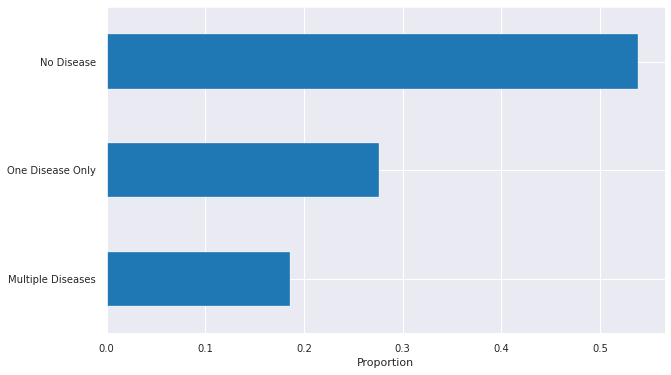

In [ ]:
# Create a copy of the disease list without 'No Finding'
diseases14 = diseases.copy()
diseases14.remove('No Finding')

# Create pd.Series corresponding to the number of observed diseases for a given patient
n_diseases = one_hot_disease_df[diseases14].sum(axis=1)

# How many patients are healthy (no diseases)?
no_disease_prop = (n_diseases == 0).mean()
print('Proportion of healthy patients:')
print(f"{no_disease_prop:.4f}\n")

# How many patients have just one disease?
one_disease_prop = (n_diseases == 1).mean()
print('Proportion of patients with 1 disease:')
print(f"{one_disease_prop:.4f}\n")

# How many patients have multiple diseases?
multi_disease_prop = (n_diseases > 1).mean()
print('Proportion of patients with more than 1 disease:')
print(f"{multi_disease_prop:.4f}\n")

# Visualize the above results
inds = ['No Disease', 'One Disease Only', 'Multiple Diseases']
props = pd.Series(
    data = [no_disease_prop, one_disease_prop, multi_disease_prop],
    index = inds
)

fig, ax = plt.subplots(figsize=(10, 6))

props[::-1].plot(kind = 'barh', ax = ax)

ax.set_xlabel('Proportion');

### Disease correlations

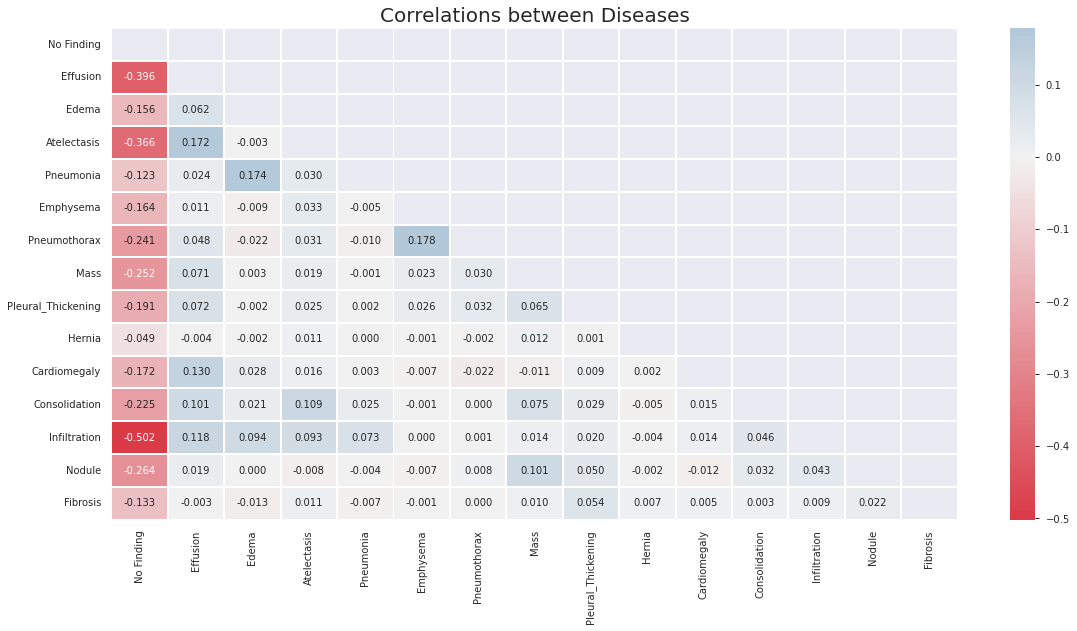

In [ ]:
# Plot heatmap of correlation matrix
corr_mat = one_hot_disease_df[diseases].corr()
bool_mask = np.triu(np.ones_like(corr_mat, dtype=bool))
cmap = sns.diverging_palette(h_neg = 10,
                             h_pos = 240,
                             as_cmap = True)

fig, ax = plt.subplots(figsize=(16, 8))

fig.tight_layout(pad = 3)

sns.heatmap(corr_mat, mask = bool_mask,
            center = 0, cmap = cmap, linewidths = 1,
            annot = True, fmt = '.3f', ax = ax)

ax.set_title('Correlations between Diseases', fontsize=20);

### Disease distribution

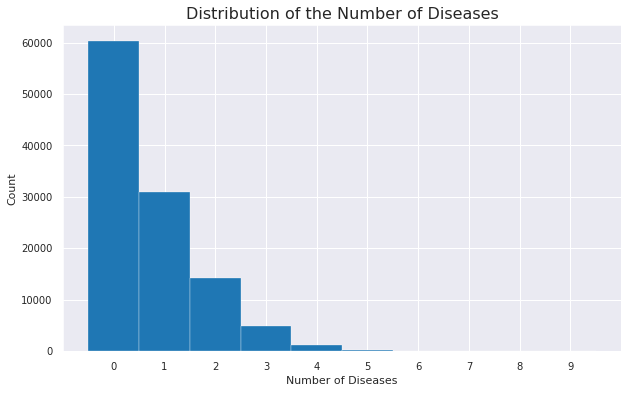

In [ ]:
# What is the distribution of n_diseases?
fig, ax = plt.subplots(figsize=(10, 6))

bins = np.arange(0, max(n_diseases.values) + 1.5) - 0.5

ax.hist(n_diseases, bins = bins)

ax.set_xticks([i for i in range(0, max(n_diseases) + 1)])
ax.set_xlabel('Number of Diseases')
ax.set_ylabel('Count')
ax.set_title('Distribution of the Number of Diseases', fontsize=16);

### Commonly occurring diseases

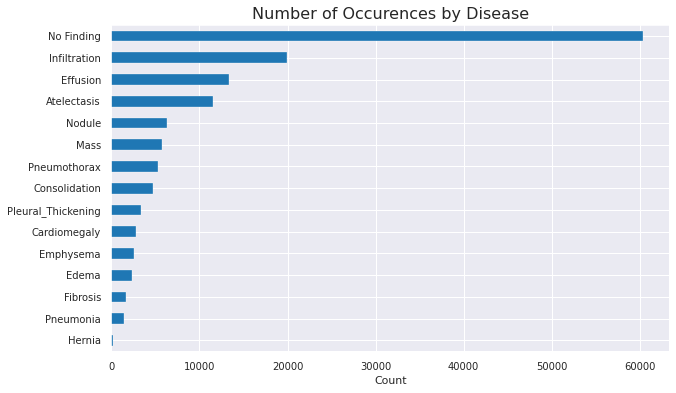

In [ ]:
# What's the most commonly occuring disease?
disease_counts = one_hot_disease_df[diseases].sum(axis = 0).sort_values(ascending = False)

fig, ax = plt.subplots(figsize=(10, 6))

disease_counts[::-1].plot(kind = 'barh', ax = ax)

ax.set_xlabel('Count')
ax.set_title('Number of Occurences by Disease', fontsize = 16);

<a name="1.3.-Major-Findings"></a>
## 1.3 Major Findings

After exploring the image data and the disease class labels, we have identified 5 major issues that will need to be addressed during data pre-processing and analysis.

1. The size of the dataset is computationally challenging. In particular:
- Images are large (1024 x 1024 pixels). We will address this problem by downscaling the images to 256 x 256 pixels using pixel area relation interpolation.
- Images are abundant (\~109K). We will address this problem by downsampling some of the more abundant image classes (esp. the 'no finding' class).

2. Patients sometimes have multiple diseases (i.e., images can have multiple labels). We will address this problem by one-hot encoding class labels and using an element-wise sigmoid activation for our model's output layer, so that we get a 0 or 1 prediction of whether an image displays evidence of a given disease or not, rather than a probability for each class (as with softmax activation). This will simultaneously address the issue that disease occurrence is correlated.

3. The 9 image categories exhibit class imbalance. We have decided to address this problem by using:
- A mix of upsampling, for diseases with few images, using data augmentation (image rotation, zooming, etc.) and downsampling for diseases with lots of images.
- A weighted loss function
- Evaluation metrics that are unaffected by class imbalance (e.g., AUROC).

4. Data leakage due to repeated X-rays for each patient.

5. Incorporating non-image data into the model. Non-image data (e.g., sex, age, patient ID) may also be predictive of disease class. We will explore model architectures that can incorporate both image and non-image data by building custom model layers.

<a name="2.-Research-Questions"></a>
# 2. Research Questions

[Return to top](#Notebook-Contents)

After initial exploration and cleaning of the data, we have focused our efforts on the following research questions:

1. Which model architecture performs best for out-of-sample classification of the X-ray images into the 14 disease classes and 'no finding' class?

2. What features in the images and which layers in the model are driving the output classification?

<a name="3.-Data-Preprocessing"></a>
# 3. Data Preprocessing

[Return to top](#Notebook-Contents)

<a name="3.1.-Image-Data"></a>
## 3.1 Image Data

### Partition image filenames into sets by patient ID

In [ ]:
# Load "train_val_list.txt"

splits_path_train_val = base_path + 'meta_data/train_val_list.txt'
splits_train_val_df = pd.read_csv(splits_path_train_val, header=None, names=['image_names'])

# Examine first 5 rows of dataframe
print(f'Shape of splits_train_val_df: {splits_train_val_df.shape}')
display(splits_train_val_df.head())

Shape of splits_train_val_df: (86524, 1)


,image_names
0,00000001_000.png
1,00000001_001.png
2,00000001_002.png
3,00000002_000.png
4,00000004_000.png


In [ ]:
# Create patient ID column
splits_train_val_df['patient_ID'] = splits_train_val_df['image_names'].apply(lambda x: re.sub('([_].*)', '', x))

# Get number of patients in train and validation sets
n_patients = len(set(splits_train_val_df['patient_ID']))
print('Number of train and validation patients:', n_patients)

Number of train and validation patients: 28008


In [ ]:
# Set the number of patients in the train and validations sets

# Use a probability of 0.7 for inclusion in training set
train_prob = 0.7

# Calculate how many patients are in each set
n_train_patients = int(np.floor(n_patients * train_prob))
n_val_patients = n_patients - n_train_patients

print('Number of train set patients:', n_train_patients)
print('Number of validation set patients:', n_val_patients)

Number of train set patients: 19605
Number of validation set patients: 8403


In [ ]:
# Get image names in train and validations sets

# Group data frame by patient ID
gb = splits_train_val_df.groupby('patient_ID')

# Get list of train and validation set unique patient IDs
train_val_patient_IDs = list(gb.groups.keys())

# Get random sample of indices for training and validation set patient IDs
random.seed(109)
train_patients_idx = random.sample(range(n_patients), k=n_train_patients)
val_patients_idx = list(set(range(n_patients)).difference(set(train_patients_idx)))
val_patients_idx = [int(i) for i in val_patients_idx]

# Get lists of train and validation set patient IDs corresponding to the above indices
train_IDs = [train_val_patient_IDs[i] for i in train_patients_idx]
val_IDs = [train_val_patient_IDs[i] for i in val_patients_idx]
print("Training set ID size sanity check:", len(train_IDs))
print("Validation set ID size sanity check:", len(val_IDs))

# Get train and validation set image names partitioned by patient IDs
train_image_names = splits_train_val_df.loc[splits_train_val_df['patient_ID'].isin(train_IDs), 'image_names'].tolist()
val_image_names = splits_train_val_df.loc[splits_train_val_df['patient_ID'].isin(val_IDs), 'image_names'].tolist()
print('Number of train set images:', len(train_image_names))
print('Number of validation set images:', len(val_image_names))

Training set ID size sanity check: 19605
Validation set ID size sanity check: 8403
Number of train set images: 60913
Number of validation set images: 25611


In [ ]:
# Load "test_list.txt"

splits_path_test = base_path + 'meta_data/test_list.txt'
splits_test_df = pd.read_csv(splits_path_test, header=None, names=['image_names'])
test_image_names = splits_test_df['image_names'].tolist()

print('Number of test set images:', len(test_image_names))

Number of test set images: 25596


### Image downsampling

In [ ]:
# KEEP = number to downsample each image class to (if disease occurance were independent)

KEEP_TOTAL = 400
KEEP_TRAIN = int(0.6 * KEEP_TOTAL) 
KEEP_VAL = int(0.2 * KEEP_TOTAL) 
KEEP_TEST = int(0.2 * KEEP_TOTAL) 

# 800 = 480 (5607), 160 (1867), 160 (1766) # 35 mins for training
# 600 = 360 (4194), 120 (1416), 120 (1342) # 25 mins for training
# 400 = 240 (2831), 80 (947), 80 (912) # 15 mins for training
# 200 = 120 (1452), 40 (495), 40 (451)

In [ ]:
# Function to downsample images filenames

def downsample_image_filenames(df, keep):
  """
  keep = number to downsample each image class to (if disease occurance were independent)
  Returns a list of terminal image filesnames without base path
  """
  # List of dieases to downsample with frequency greater than keep
  diseases_downsample = df.drop(columns='image_filename') \
                          .columns[df.drop(columns='image_filename') \
                          .sum(axis=0) > keep].tolist()
  # List of diseases to retain full sample                          
  diseases_fullsample = list(set(diseases).difference(set(diseases_downsample)))   
  # Get first n=keep image filenames for downsampled diseases
  downsample_list = [df['image_filename'][df[disease] == 1][:keep] for disease in diseases_downsample]
  # Get all image filenames for full sample diseases
  fullsample_list = [df['image_filename'][df[disease] == 1] for disease in diseases_fullsample]
  # Flatten lists
  downsample_list_flat = flatten_list(downsample_list) 
  fullsample_list_flat = flatten_list(fullsample_list)    
  # Get unique set of combined downsampled and fullsample image labels
  filenames_to_keep = list(set(downsample_list_flat + fullsample_list_flat))
  return filenames_to_keep

In [ ]:
# Function to flatten lists of lists

def flatten_list(L):
    return [item for sublist in L for item in sublist]

In [ ]:
# Function to get image filenames

def get_filenames(path, subdir):
  """
  Returns a list of full paths to image filesnames
  """
  # Path to images
  images_path = path + subdir
  # Filenames with full absolute paths
  images_filenames_full_path = glob(images_path + '/*')
  # Sort to establish consistent order
  images_filenames_full_path.sort()
  # Get terminal filenames from full path
  # images_filenames = [re.sub('^(.*[/])', '', x) for x in images_filenames_full_path]

  return images_filenames_full_path

In [ ]:
# Train label class frequencies

train_labels_df = one_hot_disease_df[one_hot_disease_df['image_filename'].isin(train_image_names)]
print(f"Train labels class frequencies: \n{train_labels_df.drop(columns='image_filename').sum(axis=0)}")

Train labels class frequencies: 
No Finding            35324
Effusion               6208
Edema                   997
Atelectasis            5856
Pneumonia               635
Emphysema               925
Pneumothorax           1872
Mass                   2919
Pleural_Thickening     1633
Hernia                   97
Cardiomegaly           1203
Consolidation          2040
Infiltration           9835
Nodule                 3382
Fibrosis                892
dtype: int64


In [ ]:
# Train downsampled label class frequencies

# Downsample image filenames
train_downsampled_image_names = downsample_image_filenames(df=train_labels_df, keep=KEEP_TRAIN)
print(f"Number of downsampled train images: {len(train_downsampled_image_names)}\n")

# Get downsampled labels
train_downsampled_labels_df = train_labels_df[train_labels_df['image_filename'].isin(train_downsampled_image_names)]
print(f"Train downsampled labels class frequencies: \n{train_downsampled_labels_df.drop(columns='image_filename').sum(axis=0)}")

Number of downsampled train images: 2831

Train downsampled labels class frequencies: 
No Finding            240
Effusion              489
Edema                 250
Atelectasis           458
Pneumonia             240
Emphysema             241
Pneumothorax          275
Mass                  267
Pleural_Thickening    257
Hernia                 97
Cardiomegaly          249
Consolidation         269
Infiltration          683
Nodule                290
Fibrosis              247
dtype: int64


In [ ]:
# Validation label class frequencies

val_labels_df = one_hot_disease_df[one_hot_disease_df['image_filename'].isin(val_image_names)]
print(f"Validation labels class frequencies: \n{val_labels_df.drop(columns='image_filename').sum(axis=0)}")

Validation labels class frequencies: 
No Finding            15176
Effusion               2451
Edema                   381
Atelectasis            2424
Pneumonia               241
Emphysema               498
Pneumothorax            765
Mass                   1115
Pleural_Thickening      609
Hernia                   44
Cardiomegaly            504
Consolidation           812
Infiltration           3947
Nodule                 1326
Fibrosis                359
dtype: int64


In [ ]:
# Validation downsampled label class frequencies

# Downsample image filenames
val_downsampled_image_names = downsample_image_filenames(df=val_labels_df, keep=KEEP_VAL)
print(f"Number of downsampled validation images: {len(val_downsampled_image_names)}\n")

# Get downsampled labels
val_downsampled_labels_df = val_labels_df[val_labels_df['image_filename'].isin(val_downsampled_image_names)]
print(f"Validation downsampled labels class frequencies: \n{val_downsampled_labels_df.drop(columns='image_filename').sum(axis=0)}")

Number of downsampled validation images: 947

Validation downsampled labels class frequencies: 
No Finding             80
Effusion              148
Edema                  81
Atelectasis           164
Pneumonia              80
Emphysema              83
Pneumothorax           83
Mass                   95
Pleural_Thickening     89
Hernia                 44
Cardiomegaly           84
Consolidation         100
Infiltration          216
Nodule                100
Fibrosis               84
dtype: int64


In [ ]:
# Test label class frequencies

test_labels_df = one_hot_disease_df[one_hot_disease_df['image_filename'].isin(test_image_names)]
print(f"Test labels class frequencies: \n{test_labels_df.drop(columns='image_filename').sum(axis=0)}")

Test labels class frequencies: 
No Finding            9861
Effusion              4658
Edema                  925
Atelectasis           3279
Pneumonia              555
Emphysema             1093
Pneumothorax          2665
Mass                  1748
Pleural_Thickening    1143
Hernia                  86
Cardiomegaly          1069
Consolidation         1815
Infiltration          6112
Nodule                1623
Fibrosis               435
dtype: int64


In [ ]:
# Train downsampled label class frequencies

# Downsample image filenames
test_downsampled_image_names = downsample_image_filenames(df=test_labels_df, keep=KEEP_TEST)
print(f"Number of downsampled test images: {len(test_downsampled_image_names)}\n")

# Get downsampled labels
test_downsampled_labels_df = test_labels_df[test_labels_df['image_filename'].isin(test_downsampled_image_names)]
print(f"Test downsampled labels class frequencies: \n{test_downsampled_labels_df.drop(columns='image_filename').sum(axis=0)}")

Number of downsampled test images: 912

Test downsampled labels class frequencies: 
No Finding             80
Effusion              169
Edema                  86
Atelectasis           145
Pneumonia              83
Emphysema              82
Pneumothorax          117
Mass                   95
Pleural_Thickening     90
Hernia                 80
Cardiomegaly           96
Consolidation         104
Infiltration          226
Nodule                 88
Fibrosis               81
dtype: int64


In [ ]:
# Get full path to filenames of all images across 12 subdirectories

# Get subdirectory names
images_subdir_list = [re.sub('^(.*[/])', '', x) for x in glob(base_path+'images_rescaled/' + '/*')]

# Get full path to filenames across all subdirectories
image_fullpath_filenames_list = [get_filenames(path=base_path+'images_rescaled/', subdir=x) for x in images_subdir_list]
image_fullpath_filenames_list_flat = flatten_list(image_fullpath_filenames_list)

print('Total number of images across 12 subdirectries:', len(image_fullpath_filenames_list_flat))

Total number of images across 12 subdirectries: 112153


In [ ]:
# Get full paths of selected images for train, validation, and test sets

train_selected_images_fullpath = [j for i in train_downsampled_image_names for j in image_fullpath_filenames_list_flat if i in j]
val_selected_images_fullpath = [j for i in val_downsampled_image_names for j in image_fullpath_filenames_list_flat if i in j]
test_selected_images_fullpath = [j for i in test_downsampled_image_names for j in image_fullpath_filenames_list_flat if i in j]

print('Number of train image full paths:', len(train_selected_images_fullpath))
print('Number of validation image full paths:', len(val_selected_images_fullpath))
print('Number of test image full paths:', len(test_selected_images_fullpath))

Number of train image full paths: 2831
Number of validation image full paths: 947
Number of test image full paths: 912


### Load images into TF datasets

In [ ]:
# Function to load the image data into TF datasets

def make_tf_image_dataset(filenames, image_size):

  def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image

  filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
  images_ds = filenames_ds.map(parse_image, num_parallel_calls=AUTOTUNE)

  return images_ds

In [ ]:
# Load the image and label data into TF datasets

# NOTE: this will load the grayscale image repeated 3 times (i.e., 3 channels)

IMG_SIZE = 224

# Create image datasets
train_images_ds = make_tf_image_dataset(filenames=train_selected_images_fullpath, image_size=IMG_SIZE)
val_images_ds = make_tf_image_dataset(filenames=val_selected_images_fullpath, image_size=IMG_SIZE)
test_images_ds = make_tf_image_dataset(filenames=test_selected_images_fullpath, image_size=IMG_SIZE)

print("train_images_ds shape: ", train_images_ds)
print("number of training images parsed: ", train_images_ds.cardinality().numpy())
print("val_images_ds shape: ", val_images_ds)
print("number of validation images parsed: ", val_images_ds.cardinality().numpy())
print("test_images_ds shape: ", test_images_ds)
print("number of testing images parsed: ", test_images_ds.cardinality().numpy())

train_images_ds shape:  <ParallelMapDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>
number of training images parsed:  2831
val_images_ds shape:  <ParallelMapDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>
number of validation images parsed:  947
test_images_ds shape:  <ParallelMapDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>
number of testing images parsed:  912


<a name="3.2.-Label-Data"></a>
## 3.2 Label Data

### Select one-hot encoded labels for train, validation, and test sets

In [ ]:
# Partition one_hot_disease_df into training, validation, and test set labels

# Reorder labels to match image order
one_hot_disease_df = one_hot_disease_df.sort_values('image_filename') 

# Get terminal filenames without full path
train_selected_images = [re.sub('^(.*[/])', '', x) for x in train_selected_images_fullpath]
val_selected_images = [re.sub('^(.*[/])', '', x) for x in val_selected_images_fullpath]
test_selected_images = [re.sub('^(.*[/])', '', x) for x in test_selected_images_fullpath]

# Logically index one_hot_disease_df based on train, validation, and test set filenames
train_selected_labels_df = one_hot_disease_df[one_hot_disease_df['image_filename'].isin(train_selected_images)]
val_selected_labels_df = one_hot_disease_df[one_hot_disease_df['image_filename'].isin(val_selected_images)]
test_selected_labels_df = one_hot_disease_df[one_hot_disease_df['image_filename'].isin(test_selected_images)]

print('Number of training labels:', train_selected_labels_df.shape)
print('Number of validation labels:', val_selected_labels_df.shape)
print('Number of test labels:', test_selected_labels_df.shape)

Number of training labels: (2831, 16)
Number of validation labels: (947, 16)
Number of test labels: (912, 16)


### Load one-hot encoded labels into TF datasets

In [ ]:
# Convert lists of one-hot encoded labels to TF datasets

# Create label datasets (remove column of image filenames first)
train_labels_ds = tf.data.Dataset.from_tensor_slices(train_selected_labels_df.drop(columns='image_filename'))
val_labels_ds = tf.data.Dataset.from_tensor_slices(val_selected_labels_df.drop(columns='image_filename'))
test_labels_ds = tf.data.Dataset.from_tensor_slices(test_selected_labels_df.drop(columns='image_filename'))  

print("train_labels_ds shape: ", train_labels_ds)
print("number of training labels parsed: ", train_labels_ds.cardinality().numpy())
print("val_labels_ds shape: ", val_labels_ds)
print("number of validation labels parsed: ", val_labels_ds.cardinality().numpy())
print("test_labels_ds shape: ", test_labels_ds)
print("number of testing labels parsed: ", test_labels_ds.cardinality().numpy())

train_labels_ds shape:  <TensorSliceDataset element_spec=TensorSpec(shape=(15,), dtype=tf.int64, name=None)>
number of training labels parsed:  2831
val_labels_ds shape:  <TensorSliceDataset element_spec=TensorSpec(shape=(15,), dtype=tf.int64, name=None)>
number of validation labels parsed:  947
test_labels_ds shape:  <TensorSliceDataset element_spec=TensorSpec(shape=(15,), dtype=tf.int64, name=None)>
number of testing labels parsed:  912


### Label class frequencies for each data partition

In [ ]:
# How many observations are in each class for the selected data partitions?

print(f"Train set class frequencies: \n{train_selected_labels_df.drop(columns='image_filename').sum(axis=0)}\n")
print(f"Validation set class frequencies: \n{val_selected_labels_df.drop(columns='image_filename').sum(axis=0)}\n")
print(f"Test set class frequencies: \n{test_selected_labels_df.drop(columns='image_filename').sum(axis=0)}\n")

Train set class frequencies: 
No Finding            240
Effusion              489
Edema                 250
Atelectasis           458
Pneumonia             240
Emphysema             241
Pneumothorax          275
Mass                  267
Pleural_Thickening    257
Hernia                 97
Cardiomegaly          249
Consolidation         269
Infiltration          683
Nodule                290
Fibrosis              247
dtype: int64

Validation set class frequencies: 
No Finding             80
Effusion              148
Edema                  81
Atelectasis           164
Pneumonia              80
Emphysema              83
Pneumothorax           83
Mass                   95
Pleural_Thickening     89
Hernia                 44
Cardiomegaly           84
Consolidation         100
Infiltration          216
Nodule                100
Fibrosis               84
dtype: int64

Test set class frequencies: 
No Finding             80
Effusion              169
Edema                  86
Atelectasis         

<a name="3.3.-Combined-Data"></a>
## 3.3 Combined Data

### Combine images and labels

In [ ]:
# Zip together the image and label data into a combined TF datasets

train_ds = tf.data.Dataset.zip((train_images_ds, train_labels_ds))
val_ds = tf.data.Dataset.zip((val_images_ds, val_labels_ds))
test_ds = tf.data.Dataset.zip((test_images_ds, test_labels_ds))

print("Train set shape: ", train_ds)
print("Validation set shape: ", val_ds)
print("Test set shape: ", test_ds)
print("number of training images/labels: ", train_ds.cardinality().numpy())
print("number of validation images/labels: ", val_ds.cardinality().numpy())
print("number of testing images/labels: ", test_ds.cardinality().numpy())

Train set shape:  <ZipDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(15,), dtype=tf.int64, name=None))>
Validation set shape:  <ZipDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(15,), dtype=tf.int64, name=None))>
Test set shape:  <ZipDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(15,), dtype=tf.int64, name=None))>
number of training images/labels:  2831
number of validation images/labels:  947
number of testing images/labels:  912


### Batching

In [ ]:
# Set up batches

BATCH_SIZE_TRAIN = 32
BATCH_SIZE_VAL = 32
BATCH_SIZE_TEST = 32

train_ds_batches = train_ds.shuffle(buffer_size=40000).batch(BATCH_SIZE_TRAIN).prefetch(buffer_size=AUTOTUNE)
val_ds_batches = val_ds.batch(BATCH_SIZE_VAL).prefetch(buffer_size=AUTOTUNE)
test_ds_batches = test_ds.batch(BATCH_SIZE_TEST).prefetch(buffer_size=AUTOTUNE)

print("Train shape: ", train_ds_batches)
print("Validation shape: ", val_ds_batches)
print("Test shape: ", test_ds_batches)

Train shape:  <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.int64, name=None))>
Validation shape:  <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.int64, name=None))>
Test shape:  <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.int64, name=None))>


In [ ]:
# Preprocessing in order to use weighted loss function
train_ds_batches = train_ds_batches.map(lambda x, y: (x, tf.cast(y, tf.float32)))
val_ds_batches = val_ds_batches.map(lambda x, y: (x, tf.cast(y, tf.float32)))
test_ds_batches = test_ds_batches.map(lambda x, y: (x, tf.cast(y, tf.float32)))

<a name="4.-Model-Training"></a>
# 4. Model Training

[Return to top](#Notebook-Contents)

In [ ]:
# Get class frequencies - used to get pos_weights, neg_weights for Weighted loss function
def get_class_frequencies(y_cols):
  """
  Returns positive and negative frequencies for each class.

  Args:
    y_cols (np.array): array of labels, size (num_observations, num_classes) i.e train_generator.labels

  Returns:
    pos_freqs (np.array): array of positive frequencies for each class, size (num_classes)
    neg_freqs (np.array): array of negative frequencies for each class, size (num_classes)

  """
  
  pos_freqs = np.mean(y_cols, axis=0) 
  neg_freqs = 1 - pos_freqs

  return pos_freqs, neg_freqs

# Weighted loss function: pos_weights = negative frequencies, neg_weights = positive frequencies (from lecture slides)

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
  """
  Return weighted loss function given negative weights and positive weights.

  Args:
    pos_weights (np.array): array of positive weights for each class, size (num_classes)
    neg_weights (np.array): array of negative weights for each class, size (num_classes)

  Returns:
    weighted_loss (function): weighted loss function.
  """
  def weighted_loss(y_true, y_pred):
    """
    Return weighted loss value.

    Args:
      y_true (Tensor): Tensor of true labels, size is (num_examples, num classes)
      y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num classes)

    Returns:
      loss (float): overall scalar loss summed across all classes.
    """
    # initialize loss to zero
    loss = 0.0

    for i in range(len(pos_weights)):
      # for each class, add average weighted loss for that class
      loss += -1. * K.mean(
          pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + epsilon) + \
          neg_weights[i] * (1 - y_true[:,i]) * K.log(1 - y_pred[:,i] + epsilon)
      )

    return loss

  return weighted_loss

def calculating_class_weights(y_true):
    from sklearn.utils.class_weight import compute_class_weight
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])
    return weights

def calculating_class_weights(y_true):
    from sklearn.utils.class_weight import compute_class_weight
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight(class_weight='balanced', classes=[0.,1.], y=y_true[:, i])
    return weights

def get_weighted_loss_2(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss

In [ ]:
# Get training weights
Y = train_selected_labels_df.drop(columns='image_filename').values
pos_freqs, neg_freqs = get_class_frequencies(Y)
pos_weights, neg_weights = neg_freqs, pos_freqs

In [ ]:
class_weights = calculating_class_weights(Y)

<a name="4.1.-Callbacks-&-Loss-Functions"></a>
## 4.1 Callbacks & Loss Functions

In [ ]:
# Callbacks

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min', 
    min_delta=0.01, 
    patience=10, 
    restore_best_weights=True, 
    verbose=True)

# Reduce learning rate by factor of 0.5 if val_coef_determination does not improve within 3 epochs
reduce_lrt_plateau = ReduceLROnPlateau(
    monitor='val_loss', 
    mode='min',
    min_delta=0.2,
    factor=0.5,
    patience=3, 
    min_lr=1e-6,
    verbose=2)

# This function keeps the initial learning rate for the first 7 epochs and decreases it exponentially after that
def scheduler(epoch, lr):
    if epoch <= 7:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lrt_scheduler = LearningRateScheduler(scheduler)

<a name="4.2.-Model-Architecture"></a>
## 4.2 Model Architecture

In [ ]:
# Pre-processing layers

# Rescale pixels
rescale_layer = Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

# Resize images for transfer learning models
TRANSFER_IMG_SIZE = 224
resize_layer = Sequential([tf.keras.layers.Resizing(height=TRANSFER_IMG_SIZE, 
                                                    width=TRANSFER_IMG_SIZE, 
                                                    interpolation='bilinear')])

# Data augmentation
data_augmentation_layer = Sequential([
  RandomRotation(0.2), 
  RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  RandomTranslation(0.2, 0.2, fill_mode='reflect', interpolation='bilinear',)
])

In [ ]:
# Define model architecture

# Parameters
INPUT_IMG_SIZE = 224
OUTPUT_DIM = 15
L1 = 1e-5
L2 = 1e-4
MAX_NORM = 2
SIGMA = 0.025

# Pass parameters in a dict
params = {'kernel_initializer': 'he_normal', 
          'kernel_regularizer': l1_l2(l1=L1, l2=L2),
          'bias_regularizer': l2(L2),
          'activity_regularizer': l2(L2),
          'kernel_constraint': MaxNorm(MAX_NORM), 
          'bias_constraint': MaxNorm(MAX_NORM)
         } 

def create_model(name='baseline_model', output_dim=OUTPUT_DIM, sigma=SIGMA, 
                 drop=0.5, transfer_model='DenseNet121'):

  # Transfer models
  if transfer_model=='ResNet50': # default input shape 224x224
      transfer_layer = ResNet50(include_top=False, weights='imagenet', 
                                input_shape=(IMG_SIZE, IMG_SIZE, 3))
  elif transfer_model=='EfficientNetB0': # default input shape 224x224
      transfer_layer = EfficientNetB0(include_top=False, weights="imagenet",
                                      input_shape=(IMG_SIZE, IMG_SIZE, 3))
  elif transfer_model=='VGG16': # default input shape 224x224
      transfer_layer = VGG16(include_top=False, weights="imagenet",
                             input_shape=(IMG_SIZE, IMG_SIZE, 3))
  elif transfer_model=='VGG19': # default input shape 224x224
      transfer_layer = VGG19(include_top=False, weights="imagenet", 
                             input_shape=(IMG_SIZE, IMG_SIZE, 3))
  elif transfer_model=='DenseNet121': # default input shape 224x224
      transfer_layer = DenseNet121(include_top=False, weights="imagenet", 
                                   input_shape=(IMG_SIZE, IMG_SIZE, 3))
      
  # Inputs, Preprocessing, and Transfer layers
  inputs = Input(shape=(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3))
  x = rescale_layer(inputs)
  x = resize_layer(x)
  #x = data_augmentation_layer(x)
  x = transfer_layer(x)
  # Extra convolutional stuff here

  # Pool for dense output
  #x = GlobalAveragePooling2D()(x)
  x = GlobalMaxPooling2D()(x)
  #x = Dropout(drop)(x)

  # Dense layers
  x = Dense(256, activation='relu', **params)(x)
  #x = GaussianNoise(stddev=sigma, seed=109)(x)
  #x = Activation('relu')(x)
  #x = Dropout(drop)(x)
  x = Dense(128, activation='relu', **params)(x)
  #x = GaussianNoise(stddev=sigma, seed=109)(x)
  #x = Activation('relu')(x)
  #x = Dropout(drop)(x)
  x = Dense(64, activation='relu', **params)(x)
  #x = GaussianNoise(stddev=sigma, seed=109)(x)
  #x = Activation('relu')(x)
  #x = Dropout(drop)(x)

  # Output layer
  outputs = Dense(output_dim, activation='sigmoid')(x)  
  model = Model(inputs=inputs, outputs=outputs, name=name)
  return model

clear_session()
model = create_model(name='DenseNet121', transfer_model='DenseNet121', drop=0.2)
model.summary()

Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_max_pooling2d (Globa  (None, 1024)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                       

<a name="4.3.-Compile-&-Train"></a>
## 4.3 Compile & Train

In [ ]:
# Compile

# Optimizers
#opt = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
#opt = Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
#opt = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
opt = Adam(learning_rate=0.000005)

# Compile model
model.compile(
    optimizer=opt, 
    loss='binary_crossentropy',
    metrics=['AUC'])

In [ ]:
#%%time

# Train the model

# Parameters
EPOCHS = 100 

# Training
history = model.fit(
    x=train_ds_batches,  
    validation_data=val_ds_batches,
    epochs=EPOCHS,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[early_stop] #[early_stop, reduce_lrt_plateau, lrt_scheduler]
    )

Epoch 1/100
89/89 [==============================] - 101s 829ms/step - loss: 2.2661 - auc: 0.4817 - val_loss: 1.5078 - val_auc: 0.4998
Epoch 2/100
89/89 [==============================] - 84s 795ms/step - loss: 1.5895 - auc: 0.5026 - val_loss: 1.4213 - val_auc: 0.5104
Epoch 3/100
89/89 [==============================] - 84s 796ms/step - loss: 1.3039 - auc: 0.5210 - val_loss: 1.3331 - val_auc: 0.5121
Epoch 4/100
89/89 [==============================] - 84s 794ms/step - loss: 1.1459 - auc: 0.5427 - val_loss: 1.2413 - val_auc: 0.5119
Epoch 5/100
89/89 [==============================] - 84s 794ms/step - loss: 1.0444 - auc: 0.5530 - val_loss: 1.1479 - val_auc: 0.5137
Epoch 6/100
89/89 [==============================] - 84s 794ms/step - loss: 0.9708 - auc: 0.5642 - val_loss: 1.0581 - val_auc: 0.5153
Epoch 7/100
89/89 [==============================] - 84s 794ms/step - loss: 0.9130 - auc: 0.5856 - val_loss: 0.9832 - val_auc: 0.5132
Epoch 8/100
89/89 [==============================] - 85s 796m

In [ ]:
# Save model
model.save(base_path + 'output/model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/CSCI_109b/cs109b_final_project/output/model/assets


In [ ]:
# Load model
model = load_model(base_path + 'output/model')

<a name="5.-Model-Evaluation"></a>
# 5. Model Evaluation

[Return to top](#Notebook-Contents)

## 5.1 Plot History

In [ ]:
def plot_history(model, title:str=''):
    """Create plots for the training history"""
    
    h = model.history.history
    y1 = h['auc']
    y2 = h['val_auc']
    y3 = h['loss']
    y4 = h['val_loss']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

    x = model.history.epoch
    ax1.plot(x, y1, label='train', linewidth=2)
    ax1.plot(x, y2, label='validation', linewidth=2)
    ax1.set_title('AUROC', fontsize=20)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('AUROC')
    best_auc = np.nanmax(y2)
    ax1.axvline(np.nanargmax(y2),
                ls='--', label=f'best val auc = {best_auc:.2f}')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(x, y3, label='train', linewidth=2)
    ax2.plot(x, y4, label='validation', linewidth=2)
    ax2.set_title('Loss', fontsize=20)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    best_loss = np.nanmin(y4)
    ax2.axvline(np.nanargmin(y4),
                ls='--', label=f'best val loss = {best_loss:.2f}')
    ax2.grid(True)
    ax2.legend()

    fig.suptitle(title, fontsize=12)

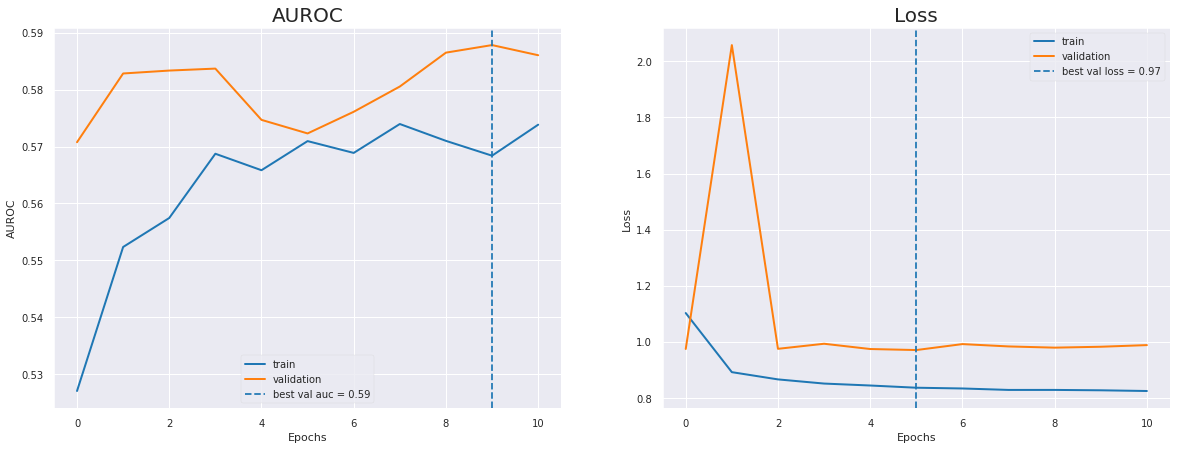

In [ ]:
# Plot training loss
plot_history(model)

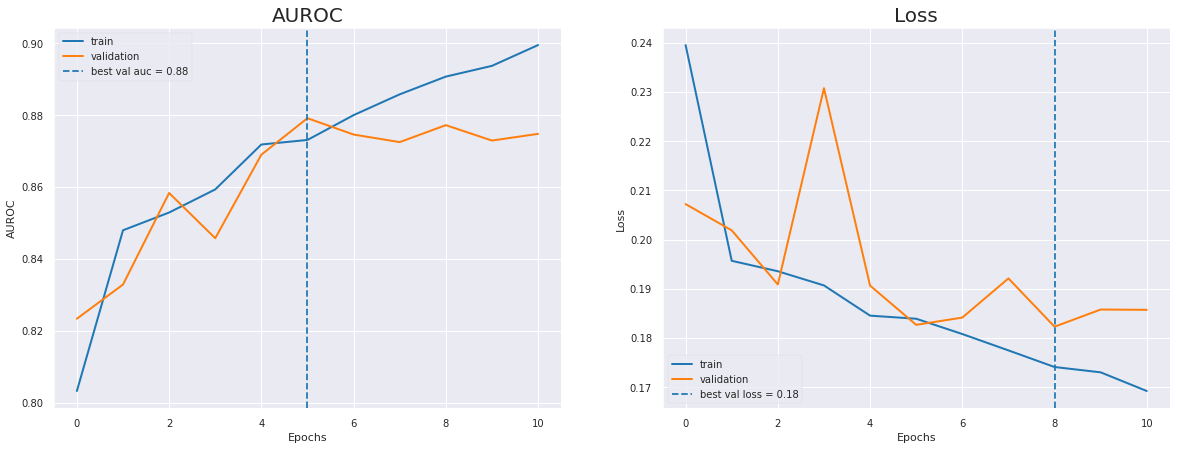

In [ ]:
# Plot training loss
plot_history(model)

## 5.2 Performance Metrics

How to set up a confusion matrix from a prefetched TF dataset?

In [ ]:
# Get classes from prefetched TF dataset

# https://stackoverflow.com/questions/64622210/how-to-extract-classes-from-prefetched-dataset-in-tensorflow-for-confusion-matri


y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds_batches:  # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = -1)) #### SET UP FOR SOFTMAX

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
predicted_labels

<tf.Tensor: shape=(220,), dtype=int64, numpy=
array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])>

In [ ]:
correct_labels

<tf.Tensor: shape=(220, 9), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])>

In [ ]:
# Confusion matrix

# print('Confusion Matrix')
# print(confusion_matrix(correct_labels, predicted_labels))

In [ ]:
# Add functions for other performance metrics here


<a name="6.-Layer-Visualizations"></a>
# 6. Layer Visualizations

[Return to top](#Notebook-Contents)

In [ ]:
# Add code for layer activation visualizations here


<a name="7.-Conclusions"></a>
# 7. Conclusions

[Return to top](#Notebook-Contents)

<a name="8.-Future-Work"></a>
# 8. Future Work

[Return to top](#Notebook-Contents)

In our analysis of the Chest X-ray dataset we have tried a variety of modeling and feature engineering approaches, but there are still many additional steps that could be taken:

1. **Incorporating non-image data into the model.** Non-image data (e.g., sex, age, patient ID) may also be predictive of disease class. Future work could explore model architectures that can incorporate both image and non-image data by building custom model layers.

2. **Additional data augmentation approaches.** Artificially coloring the images. 


<a name="9.-References"></a>
# 9. References

[Return to top](#Notebook-Contents)

Medical neural networks:
https://glassboxmedicine.com/

Comparison of ResNet50 and VGG19 and training from stratch for X-ray images dataset:
https://www.sciencedirect.com/science/article/pii/S2666285X21000558

Tensorboard confusion matrix:
https://towardsdatascience.com/exploring-confusion-matrix-evolution-on-tensorboard-e66b39f4ac12

Pre-processing and modeling pipelines (ResNet50):
https://towardsdatascience.com/time-to-choose-tensorflow-data-over-imagedatagenerator-215e594f2435

Image data input pipelines:
https://towardsdatascience.com/what-is-the-best-input-pipeline-to-train-image-classification-models-with-tf-keras-eb3fe26d3cc5

Split TF datasets:
https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438

Transfer learning with EfficientNet:
https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

Training greyscale images using transfer learning:
https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images

Multi-label vs multi-class classification:
https://glassboxmedicine.com/2019/05/26/classification-sigmoid-vs-softmax/

Multi-label classification example use-case:
https://towardsdatascience.com/fast-ai-season-1-episode-3-a-case-of-multi-label-classification-a4a90672a889

Element-wise sigmoid:
https://www.programcreek.com/python/example/93769/keras.backend.sigmoid

Element-wise sigmoid:
https://stackoverflow.com/questions/52090857/how-to-apply-sigmoid-function-for-each-outputs-in-keras

DenseNet121:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8189817/